# Языковая модель с трансформером на основе "Войны и мира"

## 1. Подготовка среды и вспомогательные функции

In [1]:
!pip install youtokentome

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for youtokentome: filename=youtokentome-1.0.6-cp311-cp311-linux_x86_64.whl size=1968568 sha256=337b981303aee16b55b0e9e833d103e6674c75e41ff00bb702f652d955fc5c1d
  Stored in directory: /root/.cache/pip/wheels/1c/7c/e2/f8069c8e5ebb9f9a26963e906ffcae4977c6322af5ecaf25fc
Successfully built youtokentome


In [2]:
# Настройка среды и импорт библиотек
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import youtokentome as yttm
import os
import math

In [3]:
# Вспомогательные функции

def init_random_seed(seed=42):
    """Инициализация случайных чисел для воспроизводимости"""
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def get_params_number(model):
    """Подсчет количества параметров модели"""
    return sum(p.numel() for p in model.parameters())

def save_texts_to_file(texts, filename):
    """Сохранение списка текстов в файл"""
    with open(filename, 'w', encoding='utf-8') as f:
        for text in texts:
            f.write(text + '\n')

def load_war_and_piece_chunks(filepath):
    """Загрузка и разбиение текста на фрагменты"""
    with open(filepath, 'r', encoding='utf-8') as f:
        text = f.read()

    # Улучшенное разбиение на предложения
    sentences = []
    current = []

    for char in text:
        current.append(char)
        if char in '.!?…"':
            if len(current) > 50:  # Минимальная длина предложения
                sentences.append(''.join(current).strip())
                current = []

    if current:
        sentences.append(''.join(current).strip())

    return sentences

## 2. Загрузка и подготовка данных

In [4]:
# Инициализация случайного seed
init_random_seed()

In [5]:
# Загрузка данных
all_chunks = load_war_and_piece_chunks('war_and_peace.txt')
print(f"Всего фрагментов: {len(all_chunks)}")

Всего фрагментов: 6599


In [6]:
# Пример текста
print("Пример фрагмента:")
print(all_chunks[10])

Пример фрагмента:
Он подошел к Анне
Павловне, поцеловал ее руку, подставив ей свою надушенную и сияющую лысину, и
покойно уселся на диване.


In [7]:
# Перемешивание и разделение на обучающую/тестовую выборки
np.random.shuffle(all_chunks)
TRAIN_SPLIT = int(len(all_chunks) * 0.7)
train_texts = all_chunks[:TRAIN_SPLIT]
test_texts = all_chunks[TRAIN_SPLIT:]

print(f"Размер обучающей выборки: {len(train_texts)}")
print(f"Размер тестовой выборки: {len(test_texts)}")

Размер обучающей выборки: 4619
Размер тестовой выборки: 1980


## 3. Обучение токенизатора

In [8]:
# Обучение BPE-токенизатора
BPE_MODEL_FILENAME = 'war_and_peace_bpe.yttm'
TRAIN_TEXTS_FILENAME = 'war_and_peace_bpe_train.txt'

save_texts_to_file(train_texts, TRAIN_TEXTS_FILENAME)

print("Обучение BPE-токенизатора...")
yttm.BPE.train(data=TRAIN_TEXTS_FILENAME, vocab_size=5000, model=BPE_MODEL_FILENAME)

tokenizer = yttm.BPE(BPE_MODEL_FILENAME)
print("Пример токенизации:", tokenizer.encode(train_texts[:1]))

Обучение BPE-токенизатора...
Пример токенизации: [[2006, 375, 1035, 1846, 423, 16, 679, 1375, 3675, 371, 1957, 199, 485, 4285, 3065, 658, 2052, 653, 2528, 1279, 375, 1035, 1851, 500, 231, 31, 2541, 260, 2627, 220, 228, 35, 1582, 1211, 375, 1035, 1901, 246, 724, 221, 991, 1055, 58]]


## 4. Преобразование текстов в токены

In [9]:
# Преобразование текстов в токены
train_token_ids = tokenizer.encode(train_texts, bos=True, eos=True)
test_token_ids = tokenizer.encode(test_texts, bos=True, eos=True)

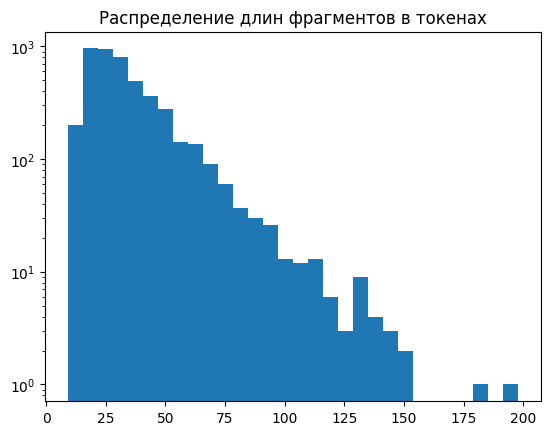

In [10]:
# Визуализация распределения длин фрагментов
plt.hist([len(sent) for sent in train_token_ids], bins=30)
plt.title('Распределение длин фрагментов в токенах')
plt.yscale('log')
plt.show()

In [11]:
# Создание датасетов
CHUNK_LENGTH = 128

class LanguageModelDataset(Dataset):
    def __init__(self, token_ids, chunk_length=CHUNK_LENGTH):
        self.token_ids = token_ids
        self.chunk_length = chunk_length

    def __len__(self):
        return len(self.token_ids)

    def __getitem__(self, idx):
        tokens = self.token_ids[idx]
        tokens = tokens[:self.chunk_length]
        if len(tokens) == 0:  # Пропуск пустых последовательностей
            return torch.zeros(self.chunk_length, dtype=torch.long)
        padded_tokens = tokens + [0] * (self.chunk_length - len(tokens))
        return torch.tensor(padded_tokens)

train_dataset = LanguageModelDataset(train_token_ids, chunk_length=CHUNK_LENGTH)
test_dataset = LanguageModelDataset(test_token_ids, chunk_length=CHUNK_LENGTH)

In [12]:
# Пример из датасета
sample = train_dataset[0]
print("Пример из датасета:", sample)
print("Декодированный пример:", tokenizer.decode([x.item() for x in sample]))

Пример из датасета: tensor([   2, 2006,  375, 1035, 1846,  423,   16,  679, 1375, 3675,  371, 1957,
         199,  485, 4285, 3065,  658, 2052,  653, 2528, 1279,  375, 1035, 1851,
         500,  231,   31, 2541,  260, 2627,  220,  228,   35, 1582, 1211,  375,
        1035, 1901,  246,  724,  221,  991, 1055,   58,    3,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])
Декодированный пример: ['<BOS> ] (сноска 51) Я, право, опасаюсь за свои способности перед такой публикой, (сноска 52) Подож

## 5. Определение модели

In [13]:
# Вспомогательные функции для модели

def make_target_dependency_mask(length):
    """Создание маски для зависимости между токенами"""
    full_mask = torch.ones(length, length)
    ignore_mask = torch.tril(full_mask) < 1
    full_mask.masked_fill_(ignore_mask, float('-inf'))
    full_mask.masked_fill_(~ignore_mask, 0)
    return full_mask

def make_positional_encoding(max_length, embedding_size):
    """Создание позиционных кодировок"""
    time = np.pi * torch.arange(0, max_length).float()
    freq_dividers = torch.arange(1, embedding_size // 2 + 1).float()
    inputs = time[:, None] / freq_dividers[None, :]

    result = torch.zeros(max_length, embedding_size)
    result[:, 0::2] = torch.sin(inputs)
    result[:, 1::2] = torch.cos(inputs)
    return result

In [14]:
# Определение модели

class BatchFirstTransformerEncoder(nn.Module):
    """Transformer Encoder с поддержкой batch-first формата"""
    def __init__(self, *args, **kwargs):
        super().__init__()
        self.impl = nn.TransformerEncoder(*args, **kwargs)
        self.initialize_weights()

    def forward(self, src, *args, **kwargs):
        src = src.transpose(0, 1).contiguous()
        result = self.impl(src, *args, **kwargs)
        result = result.transpose(0, 1).contiguous()
        return result

    def initialize_weights(self):
        for param in self.impl.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)

class LanguageModel(nn.Module):
    """Языковая модель на основе трансформера"""
    def __init__(self, vocab_size, embedding_size, backbone, emb_dropout=0.0):
        super().__init__()
        self.embedding_size = embedding_size
        self.embeddings = nn.Embedding(vocab_size, embedding_size, padding_idx=0)
        self.emb_dropout = nn.Dropout(emb_dropout)
        self.backbone = backbone
        self.out = nn.Linear(embedding_size, vocab_size)

        # Кэш позиционных кодировок
        self.pos_encoding_cache = {}

    def forward(self, seed_token_ids):
        batch_size, max_in_length = seed_token_ids.shape
        seed_padding_mask = (seed_token_ids == 0).to(seed_token_ids.device)

        # Создаем маску на правильном устройстве
        dependency_mask = make_target_dependency_mask(max_in_length).to(seed_token_ids.device)

        seed_embs = self.embeddings(seed_token_ids)

        # Создаем позиционные кодировки на нужном устройстве
        if max_in_length not in self.pos_encoding_cache:
            pos_codes = make_positional_encoding(max_in_length, self.embedding_size)
            self.pos_encoding_cache[max_in_length] = pos_codes.to(seed_token_ids.device)

        seed_embs = seed_embs + self.pos_encoding_cache[max_in_length][:max_in_length, :]
        seed_embs = self.emb_dropout(seed_embs)

        target_features = self.backbone(seed_embs, mask=dependency_mask, src_key_padding_mask=seed_padding_mask)
        logits = self.out(target_features)
        return logits

    # Свойство для определения устройства
    @property
    def device(self):
        return next(self.parameters()).device

In [15]:
# Функция потерь
def lm_cross_entropy(pred, target):
    """Функция потерь со сдвигом целей на один токен"""
    pred_flat = pred[:, :-1, :].contiguous().view(-1, pred.shape[-1])  # Убираем последний токен предсказаний
    target_flat = target[:, 1:].contiguous().view(-1)  # Сдвигаем цели на один токен
    return F.cross_entropy(pred_flat, target_flat, ignore_index=0)

In [44]:
# Создание модели
torch_transf_model = LanguageModel(
    tokenizer.vocab_size(),
    512,
    BatchFirstTransformerEncoder(
        nn.TransformerEncoderLayer(
            d_model=512,
            nhead=8,
            dim_feedforward=2048,
            dropout=0.2,
            layer_norm_eps=1e-5,
        ),
        num_layers=6
    ),
    emb_dropout=0.2
)
print(f'Количество параметров: {get_params_number(torch_transf_model):,}')

Количество параметров: 24,039,304


## 6. Обучение модели

In [45]:
# Функция обучения
def train_eval_loop(model, train_dataset, test_dataset, loss_func,
                    lr=1e-3, epoch_n=100, batch_size=32, device='cuda',
                    early_stopping_patience=10, max_batches_per_epoch_train=100,
                    max_batches_per_epoch_val=100, lr_scheduler_ctor=None):
    """Обучающий цикл с оценкой качества"""
    # optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    optimizer = torch.optim.AdamW(
    torch_transf_model.parameters(),
    lr=lr,
    betas=(0.9, 0.98),
    eps=1e-9,
    weight_decay=0.01)
    scheduler = lr_scheduler_ctor(optimizer) if lr_scheduler_ctor else None

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    best_loss = float('inf')
    best_model = None
    no_improvement = 0

    model = model.to(device)

    for epoch in range(epoch_n):
        model.train()
        train_loss = 0.0

        for batch_i, batch in enumerate(train_loader):
            if batch_i >= max_batches_per_epoch_train:
                break

            inputs = batch.to(device)
            targets = inputs.clone()

            optimizer.zero_grad()
            logits = model(inputs)
            loss = loss_func(logits, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_i, batch in enumerate(test_loader):
                if batch_i >= max_batches_per_epoch_val:
                    break

                inputs = batch.to(device)
                targets = inputs.clone()
                logits = model(inputs)
                loss = loss_func(logits, targets)
                val_loss += loss.item()

        train_loss /= max_batches_per_epoch_train
        val_loss /= max_batches_per_epoch_val

        if scheduler:
            scheduler.step(val_loss)

        print(f'Epoch {epoch+1}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}')

        if val_loss < best_loss:
            best_loss = val_loss
            best_model = model.state_dict()
            no_improvement = 0
        else:
            no_improvement += 1

        if no_improvement >= early_stopping_patience:
            print("Early stopping triggered")
            break

    model.load_state_dict(best_model)
    return best_loss, model

In [46]:
# Обучение модели
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Используется устройство: {device}")

def lr_scheduler(optimizer):
    return torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer,
        T_0=10,
        T_mult=2,
        eta_min=1e-6
    )

(best_val_loss, best_torch_transf_model) = train_eval_loop(
    torch_transf_model,
    train_dataset,
    test_dataset,
    lm_cross_entropy,
    lr=1e-4,
    epoch_n=500,
    batch_size=128,
    device=device,
    early_stopping_patience=10,
    max_batches_per_epoch_train=500,
    max_batches_per_epoch_val=200,
    lr_scheduler_ctor=lr_scheduler
)

Используется устройство: cuda
Epoch 1: Train Loss=0.5811, Val Loss=0.5968
Epoch 2: Train Loss=0.5504, Val Loss=0.5859
Epoch 3: Train Loss=0.5433, Val Loss=0.5777
Epoch 4: Train Loss=0.5362, Val Loss=0.5709
Epoch 5: Train Loss=0.5311, Val Loss=0.5649
Epoch 6: Train Loss=0.5244, Val Loss=0.5576
Epoch 7: Train Loss=0.5175, Val Loss=0.5511
Epoch 8: Train Loss=0.5109, Val Loss=0.5433
Epoch 9: Train Loss=0.5045, Val Loss=0.5380
Epoch 10: Train Loss=0.4990, Val Loss=0.5334
Epoch 11: Train Loss=0.4935, Val Loss=0.5286
Epoch 12: Train Loss=0.4882, Val Loss=0.5239
Epoch 13: Train Loss=0.4841, Val Loss=0.5200
Epoch 14: Train Loss=0.4793, Val Loss=0.5161
Epoch 15: Train Loss=0.4750, Val Loss=0.5112
Epoch 16: Train Loss=0.4702, Val Loss=0.5072
Epoch 17: Train Loss=0.4663, Val Loss=0.5038
Epoch 18: Train Loss=0.4617, Val Loss=0.5003
Epoch 19: Train Loss=0.4576, Val Loss=0.4964
Epoch 20: Train Loss=0.4534, Val Loss=0.4925
Epoch 21: Train Loss=0.4491, Val Loss=0.4897
Epoch 22: Train Loss=0.4454, Val L

In [49]:
# Сохранение и загрузка лучшей модели
torch.save(best_torch_transf_model.state_dict(), 'war_and_peace_torch_transf_best.pth')
print("Модель сохранена")

Модель сохранена


In [50]:
# Загрузка сохраненной модели
torch_transf_model.load_state_dict(torch.load('war_and_peace_torch_transf_best.pth'))

<All keys matched successfully>

## 7. Генерация текста

In [51]:
# Класс для генерации текста
class GreedyGenerator:
    """Жадный генератор текста с кэшированием"""
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer

    def __call__(self, seed_text, max_len=50):
        self.model.eval()
        tokens = self.tokenizer.encode([seed_text], bos=True)[0]
        device = self.model.device
        tokens_tensor = torch.tensor(tokens).unsqueeze(0).to(device)

        with torch.no_grad():
            for _ in range(max_len):
                # Используем только последние CHUNK_LENGTH токенов
                input_tokens = tokens_tensor[:, -CHUNK_LENGTH:]

                logits = self.model(input_tokens)
                next_token = torch.argmax(logits[0, -1, :])

                # Проверяем EOS (конец последовательности)
                if next_token.item() == 3:  # EOS token
                    break

                tokens.append(next_token.item())
                tokens_tensor = torch.tensor(tokens).unsqueeze(0).to(device)

        return self.tokenizer.decode(tokens)[0]

In [56]:
# Генерация текста
greedy_generator = GreedyGenerator(torch_transf_model, tokenizer)

print("\nГенерация текста:")
print(greedy_generator('сказала княжна, оглядывая '))
print(greedy_generator('смеялась княжна, оглядывая '))
print(greedy_generator('Наполеон хочет '))


Генерация текста:
<BOS> сказала княжна, оглядывая на Анну Павловна.
<BOS> смеялась княжна, оглядывая на него и на него глазами, ногу, что он не мог понять, что он был в том, что он был в том, что он был в душе.
<BOS> Наполеон хочет еще не мог понять, как будто он был в том, что он был в том, что он был в Петербурге, и что он был в душе в Петербурге, и что он был в этом случае должно было бы мог бы мог бы мог бы мог бы мог
